In [1]:
import os
os.getcwd()

'/home/apolloreno/repos/personal_repositories/decorrelating_errors/data/one_qubit_numeric'

In [2]:
from pauli_channel_approximation import PCA

In [3]:
import dill
with open('0_pickled_controls5.pkl', 'rb') as f:
    data0 = dill.load(f)
with open('1_pickled_controls5.pkl', 'rb') as f:
    data1 = dill.load(f)


In [4]:
import numpy as np
import scipy as sp
import numpy.linalg as lin
import scipy.linalg as slin

import os; os.environ['PYGSTI_BACKCOMPAT_WARNING'] = '0'
import pygsti 

try:
    from matplotlib import pyplot as plt
    import seaborn as sns
    sns.set_style('white')
    %matplotlib inline
except ImportError:
    pass


In [5]:
sigI = np.array([[1.,0],[0, 1]], dtype='complex')
sigX = np.array([[0, 1],[1, 0]], dtype='complex')
sigY = np.array([[0,-1],[1, 0]], dtype='complex') * 1.j
sigZ = np.array([[1, 0],[0,-1]], dtype='complex')
sigM = (sigX - 1.j*sigY)/2.
sigP = (sigX + 1.j*sigY)/2.

In [6]:
import pygsti
import numpy as np
import itertools
from functools import reduce

multi_kron = lambda *a: reduce(np.kron, a)

def change_basis(process, from_basis, to_basis):
    """
    PyGSTi 'std' basis is *row stacked* rather than column stacked, so need to defined a 'col' basis.
    """
    allowed_bases = ['col', 'std', 'gm', 'pp', 'qsim']
    if not ((from_basis in allowed_bases) or (to_basis in allowed_bases)):
        raise ValueError("Allowed bases are 'col', 'std', 'gm', 'pp', 'qsim' ")

    n_qubits = int(np.log(len(process)) / np.log(4))
    if from_basis == 'col' or to_basis == 'col':

        if len(process) != 4**n_qubits:
            raise ValueError('The dimension of the process matrix must be a power of 4.')
        def matrix_unit(n,i,j):
            unit = np.zeros([n,n], dtype='complex')
            unit[i,j] = 1.
            return unit
        col_stacked_matrix_units = [matrix_unit(2**n_qubits, i, j) for j in range(2**n_qubits) for i in range(2**n_qubits)]

        from pygsti.objects import ExplicitBasis
        col = ExplicitBasis(col_stacked_matrix_units, ["myElement%d" % i for i in range(4**n_qubits)],
                                     name='col', longname='Column=-Stacked')
        if from_basis == 'col':
            from_basis = col
        if to_basis == 'col':
            to_basis = col

    if from_basis == 'qsim' or to_basis == 'qsim':
        n_qubits = int(np.log(len(process))/np.log(4))
        if len(process) != 4**n_qubits:
            raise ValueError('The dimension of the process matrix must be a power of 4.')
        sig0q = np.array([[1., 0], [0, 0]], dtype='complex')
        sigXq = np.array([[0, 1], [1, 0]], dtype='complex')/np.sqrt(2)
        sigYq = np.array([[0, -1], [1, 0]], dtype='complex') * 1.j / np.sqrt(2.)
        sig1q = np.array([[0, 0], [0, 1]], dtype='complex')
        qbasis = itertools.product([sig0q, sigXq, sigYq, sig1q], repeat=n_qubits)
        qbasis = [multi_kron(*x) for x in qbasis]

        from pygsti.objects import ExplicitBasis
        qsim = ExplicitBasis(qbasis, ["myElement%d" % i for i in range(4**n_qubits)],
                                     name='qsim', longname='Quantumsim')
        if from_basis == 'qsim':
            from_basis = qsim
        if to_basis == 'qsim':
            to_basis = qsim

    return pygsti.tools.basistools.change_basis(process, from_basis, to_basis)

In [7]:
def get_unitary(data, c_ind, epsilon1, delta1):
    u = np.eye(2, dtype='complex')
    a = epsilon1 * data.ambient_hamiltonian[0]
    h0 = a
    for t_ind in range(25):
        f = (1 + delta1) * data.controlset[c_ind][t_ind][0] * data.control_hamiltonians[0]
        g = (1 + delta1) * data.controlset[c_ind][t_ind][1] * data.control_hamiltonians[1]
        ham = h0 + f + g
        u = np.dot(slin.expm(-1.j * ham * data.dt), u)
    return u

In [8]:
sqrt_x = data1.target_operator
psqrt_x = np.kron(sqrt_x.conj(), sqrt_x) 
psqrt_x = change_basis(psqrt_x, 'col', 'pp')

# Figures for paper

In [10]:
# Load the 1MQG and 0MQG data
with open('./0_epsilon_1q.dat', 'rb') as f:
    ep0 = dill.load(f)
with open('./figures/1_epsilon_1q.dat', 'rb') as f:
    ep1 = dill.load(f)

FileNotFoundError: [Errno 2] No such file or directory: './0_epsilon_1q.dat'

In [10]:
ind = 9
ed = []
for val in ep0['vals']:
    u = get_unitary(data1, ind,val,0)
    pu = change_basis(np.kron(u.conj(), u), 'col', 'pp')
    ed += [pygsti.tools.optools.diamonddist(psqrt_x, pu, 'pp')/2]

In [11]:
# ind = 11
# ed = []
# for val in ep0['vals']:
#     u = get_unitary(data1, ind,val,val,0,0)
#     pu = change_basis(np.kron(u.conj(), u), 'col', 'pp')
#     ed += [pygsti.tools.optools.diamonddist(piSWAP, pu, 'pp')/2]
# distances[ind] = ed.copy()

In [12]:
plt.hist(ed, bins=30)

(array([122.,  58.,  46.,  44.,  40.,  38.,  38.,  36.,  36.,  36.,  35.,
         35.,  34.,  34.,  34.,  34.,  34.,  34.,  33.,  33.,  18.,  17.,
         16.,  17.,  16.,  17.,  16.,  17.,  16.,  17.]),
 array([0.00114492, 0.00131531, 0.00148569, 0.00165608, 0.00182646,
        0.00199685, 0.00216723, 0.00233762, 0.002508  , 0.00267839,
        0.00284878, 0.00301916, 0.00318955, 0.00335993, 0.00353032,
        0.0037007 , 0.00387109, 0.00404147, 0.00421186, 0.00438224,
        0.00455263, 0.00472302, 0.0048934 , 0.00506379, 0.00523417,
        0.00540456, 0.00557494, 0.00574533, 0.00591571, 0.0060861 ,
        0.00625648]),
 <a list of 30 Patch objects>)

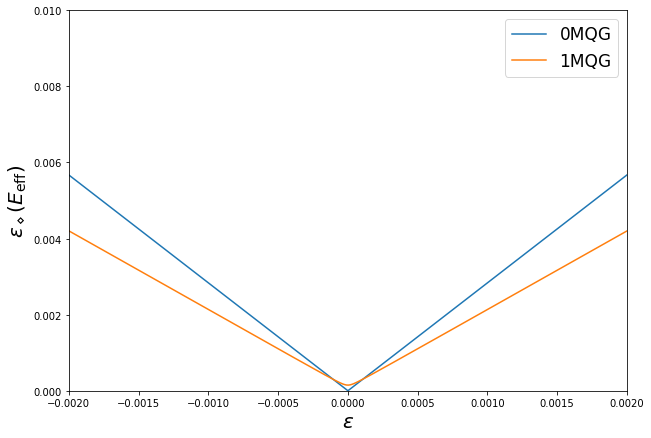

In [13]:
%matplotlib inline
plt.figure(figsize=(10,7))
plt.plot(ep0['vals'], ep0['diamond_distances'], label='Generator-exact MQG')
plt.plot(ep1['vals'], ep1['diamond_distances'], label='Robust generator-exact MQG')
plt.xlabel("$\epsilon$", fontsize=20)
plt.ylabel("$\epsilon_\diamond(E_{\mathrm{eff}})$", fontsize=20)
plt.ylim(0,0.01)
plt.xlim(-0.002, 0.002)
plt.legend(fontsize=17)

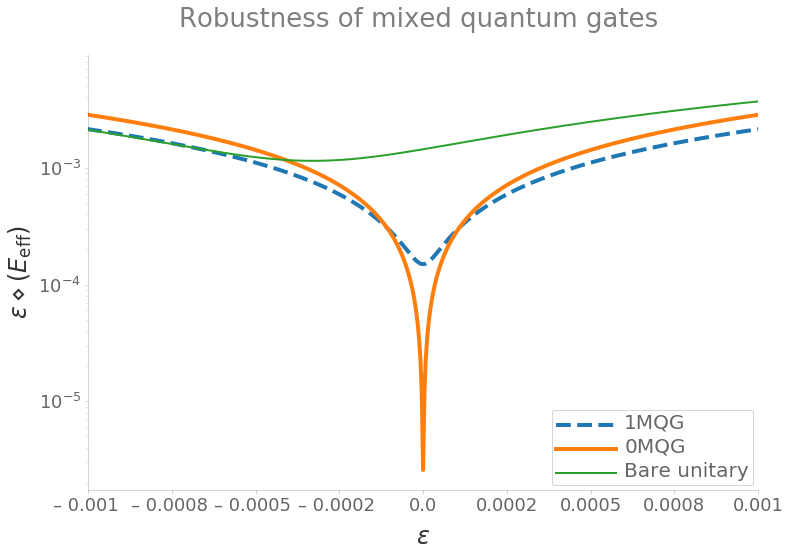

In [14]:
import matplotlib 

matplotlib.rc('font', serif='Helvetica Neue') 
fig, ax = plt.subplots(figsize=(12,8))

colors = ["#f7fcfd","#e5f5f9","#ccece6","#99d8c9","#66c2a4","#41ae76","#238b45","#006d2c","#00441b","#00200f"]

ax.plot(ep1['vals'], ep1['diamond_distances'], label='Robust generator-exact MQG', linewidth=4, linestyle='--')#, color='#1f78b4')
ax.plot(ep0['vals'], ep0['diamond_distances'], label='Generator-exact MQG', linewidth=4)#, color = '#e34a33')
ax.plot(ep0['vals'], ed, label='Bare unitary', linewidth=2)
    
# ax.set_ylim([1.e-5,1.e-2])
# ax.set_xlim([t_final-2.5*9.e-8, t_final+2.5*9.e-8])
plt.xlabel("$\epsilon$", fontsize=24, alpha=.8)
plt.ylabel("$\epsilon\diamond(E_{\mathrm{eff}})$", fontsize=24, alpha=0.8)
#plt.ylim(0,0.005)
plt.xlim(-0.001, 0.001)
plt.yscale('log')


ax.set_title('Robustness of mixed quantum gates ',fontsize=26,alpha=.5,y=1.05)

for ticklabel in ax.get_yticklabels() + ax.get_xticklabels():
    ticklabel.set_fontsize(18)
    ticklabel.set_alpha(0.6)
    
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)    
ax.spines["bottom"].set_alpha(.2)
ax.spines["left"].set_alpha(.2)    

ax.xaxis.labelpad = 10
# ax.set_xlim(19.4e-6,20.6e-6)
# ax.set_ylim(9.e-6,.1)

ax.get_xaxis().tick_bottom()    
ax.get_yaxis().tick_left()    

for line in ax.get_xticklines() + ax.yaxis.get_ticklines(minor=True) + ax.yaxis.get_ticklines():
    line.set_alpha(.2)

leg = ax.legend(loc="lower right", fancybox=True, handlelength=6)
for text in leg.get_texts():
    text.set_alpha(.6)
    text.set_fontsize(20)
leg.get_title().set_fontsize(22)
leg.get_title().set_alpha(0.7)

leg.get_frame().set_facecolor('#FFFFFF')
leg.get_frame().set_edgecolor('#CCCCCC')
leg.set_zorder(1000)

import matplotlib.ticker as tick
def x_fmt(x, y):
    return u'\u2013 '*int(x < 0) + str(round(abs(x) ,4)) +  ' '*int(x < 0)

ax.xaxis.set_major_formatter(tick.FuncFormatter(x_fmt))
    


(-0.009, 0.009)

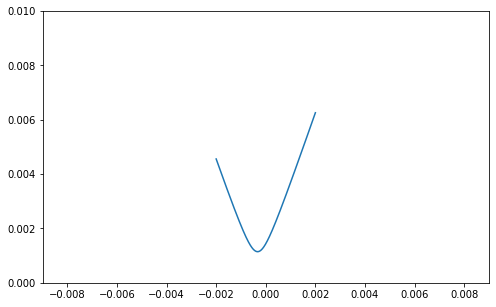

In [15]:
plt.figure(figsize = (8,5))
plt.plot(ep1['vals'], ed)
plt.ylim(0,0.01)
plt.xlim(-0.009, 0.009)

In [16]:
%matplotlib inline

In [17]:
import scipy as sp

In [18]:

sp.stats.mode([11,2,3,4,4])[0][0]

4

In [19]:
from scipy import signal

In [20]:
#signal.convolve?

In [21]:
# plt.plot(np.cos(np.linspace(-2,2,100)))
# plt.plot(signal.convolve(np.cos(np.linspace(-2,2,100)), np.ones(5)/5), method='direct')

# Computed Diamond Norms

In [13]:
# Load the 1MQG and 0MQG data
with open('./figures/0_epsilon_1q.dat', 'rb') as f:
    ep0 = dill.load(f)
with open('./figures/1_epsilon_1q.dat', 'rb') as f:
    ep1 = dill.load(f)

FileNotFoundError: [Errno 2] No such file or directory: './figures/0_epsilon_1q.dat'

In [11]:
with open('1q_dnorms_epsilon.dat', 'rb') as f:
    data = dill.load(f)

NameError: name 'ep1' is not defined

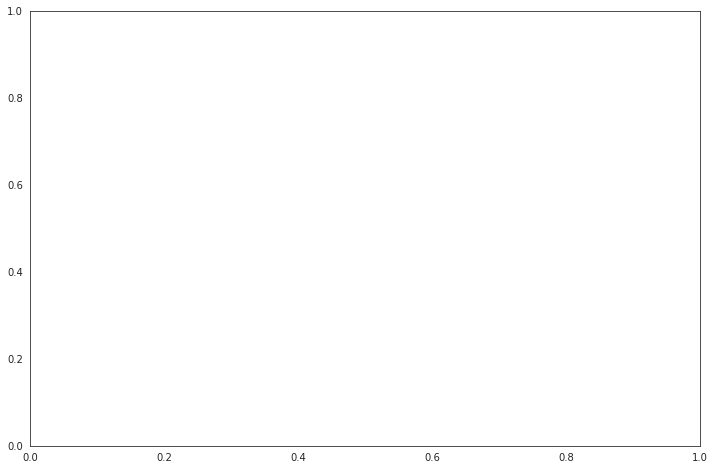

In [12]:
import matplotlib 

matplotlib.rc('font', serif='Helvetica Neue') 
fig, ax = plt.subplots(figsize=(12,8))

colors = ["#f7fcfd","#e5f5f9","#ccece6","#99d8c9","#66c2a4","#41ae76","#238b45","#006d2c","#00441b","#00200f"]

ax.plot(ep1['vals'], ep1['diamond_distances'], label='Robust generator-exact MQG', linewidth=4, linestyle='--')#, color='#1f78b4')
ax.plot(ep0['vals'], ep0['diamond_distances'], label='Generator-exact MQG', linewidth=4)#, color = '#e34a33')

xvals = np.array(data['epsilons'])
for ind in range(10):
    yvals = np.array(data[ind])
    # Sometimes the diamond norm calculation fails:
    worked = yvals > 0
    xs = xvals[worked]
    ys = yvals[worked]
    if ind == 0:
        ax.plot(xs,ys, label='Bare unitary', linewidth=.7, alpha = .1, color = 'k')
    else:
        ax.plot(xs,ys, linewidth=.7, alpha = .1, color = 'k')
    
plt.xlabel("$\epsilon$", fontsize=24, alpha=.8)
plt.ylabel("$\epsilon\diamond(E_{\mathrm{eff}})$", fontsize=24, alpha=0.8)
#plt.ylim(0,0.01)
plt.yscale('log')
plt.xlim(-0.002, 0.002)

ax.set_title('Robustness of mixed quantum gates ',fontsize=26,alpha=.5,y=1.05)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)    
ax.spines["bottom"].set_alpha(.2)
ax.spines["left"].set_alpha(.2)    

# ax.set_xlim(19.4e-6,20.6e-6)
# ax.set_ylim(9.e-6,.1)

ax.xaxis.labelpad = 10
ax.get_xaxis().tick_bottom()    
ax.get_yaxis().tick_left()    
for line in ax.get_xticklines() + ax.yaxis.get_ticklines(minor=True) + ax.yaxis.get_ticklines():
    line.set_alpha(.2)
import matplotlib.ticker as tick
def x_fmt(x, y):
    return u'\u2013 '*int(x < 0) + str(round(abs(x) ,4)) +  ' '*int(x < 0)
ax.xaxis.set_major_formatter(tick.FuncFormatter(x_fmt))
for ticklabel in ax.get_yticklabels() + ax.get_xticklabels():
    ticklabel.set_fontsize(18)
    ticklabel.set_alpha(0.6)

    
# Legend
leg = ax.legend(loc="lower right", fancybox=True, handlelength=6)
for text in leg.get_texts():
    text.set_alpha(.6)
    text.set_fontsize(20)
leg.get_title().set_fontsize(22)
leg.get_title().set_alpha(0.7)

leg.get_frame().set_facecolor('#FFFFFF')
leg.get_frame().set_edgecolor('#CCCCCC')
leg.set_zorder(1000)

plt.savefig('./figures/1q_robustness_epsilon.pdf')
    


# Delta

In [49]:
# Load the 1MQG and 0MQG data
with open('./figures/0_delta_1q.dat', 'rb') as f:
    ep0 = dill.load(f)
with open('./figures/1_delta_1q.dat', 'rb') as f:
    ep1 = dill.load(f)

In [50]:
with open('1q_dnorms_delta.dat', 'rb') as f:
    data = dill.load(f)

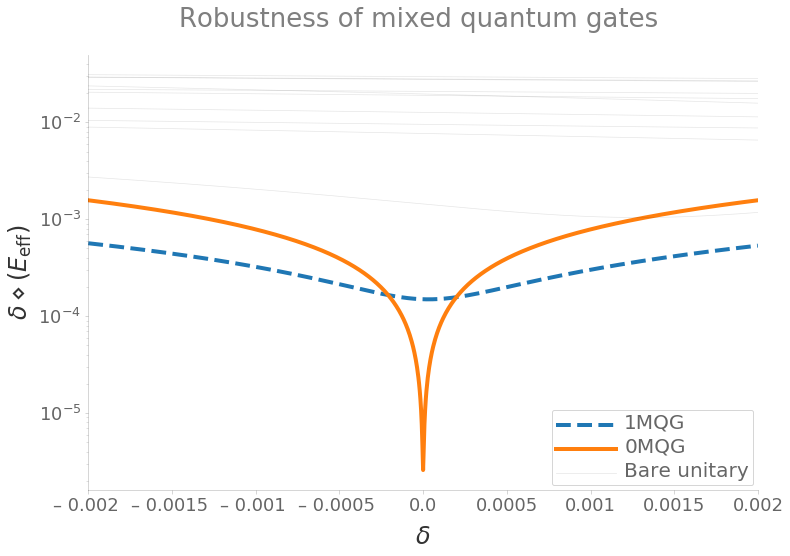

In [53]:
import matplotlib 

matplotlib.rc('font', serif='Helvetica Neue') 
fig, ax = plt.subplots(figsize=(12,8))

colors = ["#f7fcfd","#e5f5f9","#ccece6","#99d8c9","#66c2a4","#41ae76","#238b45","#006d2c","#00441b","#00200f"]

ax.plot(ep1['vals'], ep1['diamond_distances'], label='Robust generator-exact MQG', linewidth=4, linestyle='--')#, color='#1f78b4')
ax.plot(ep0['vals'], ep0['diamond_distances'], label='Generator-exact MQG', linewidth=4)#, color = '#e34a33')

xvals = np.array(data['epsilons'])
for ind in range(10):
    yvals = np.array(data[ind])
    # Sometimes the diamond norm calculation fails:
    worked = yvals > 0
    xs = xvals[worked]
    ys = yvals[worked]
    if ind == 0:
        ax.plot(xs,ys, label='Bare unitary', linewidth=.7, alpha = .1, color = 'k')
    else:
        ax.plot(xs,ys, linewidth=.7, alpha = .1, color = 'k')
    
plt.xlabel("$\delta$", fontsize=24, alpha=.8)
plt.ylabel("$\delta\diamond(E_{\mathrm{eff}})$", fontsize=24, alpha=0.8)
#plt.ylim(0,0.01)
plt.yscale('log')
plt.xlim(-0.002, 0.002)

ax.set_title('Robustness of mixed quantum gates ',fontsize=26,alpha=.5,y=1.05)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)    
ax.spines["bottom"].set_alpha(.2)
ax.spines["left"].set_alpha(.2)    

# ax.set_xlim(19.4e-6,20.6e-6)
# ax.set_ylim(9.e-6,.1)

ax.xaxis.labelpad = 10
ax.get_xaxis().tick_bottom()    
ax.get_yaxis().tick_left()    
for line in ax.get_xticklines() + ax.yaxis.get_ticklines(minor=True) + ax.yaxis.get_ticklines():
    line.set_alpha(.2)
import matplotlib.ticker as tick
def x_fmt(x, y):
    return u'\u2013 '*int(x < 0) + str(round(abs(x) ,4)) +  ' '*int(x < 0)
ax.xaxis.set_major_formatter(tick.FuncFormatter(x_fmt))
for ticklabel in ax.get_yticklabels() + ax.get_xticklabels():
    ticklabel.set_fontsize(18)
    ticklabel.set_alpha(0.6)

    
# Legend
leg = ax.legend(loc="lower right", fancybox=True, handlelength=6)
for text in leg.get_texts():
    text.set_alpha(.6)
    text.set_fontsize(20)
leg.get_title().set_fontsize(22)
leg.get_title().set_alpha(0.7)

leg.get_frame().set_facecolor('#FFFFFF')
leg.get_frame().set_edgecolor('#CCCCCC')
leg.set_zorder(1000)

plt.savefig('./figures/1q_robustness_delta.pdf')
    

